**Ejercicio 22 : BERNAL AGUILAR ITALIA**


*Simulación MC de precios*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Datos de las acciones de Microsoft
[*********************100%***********************]  1 of 1 completed
Descargados 102 renglones de datos.


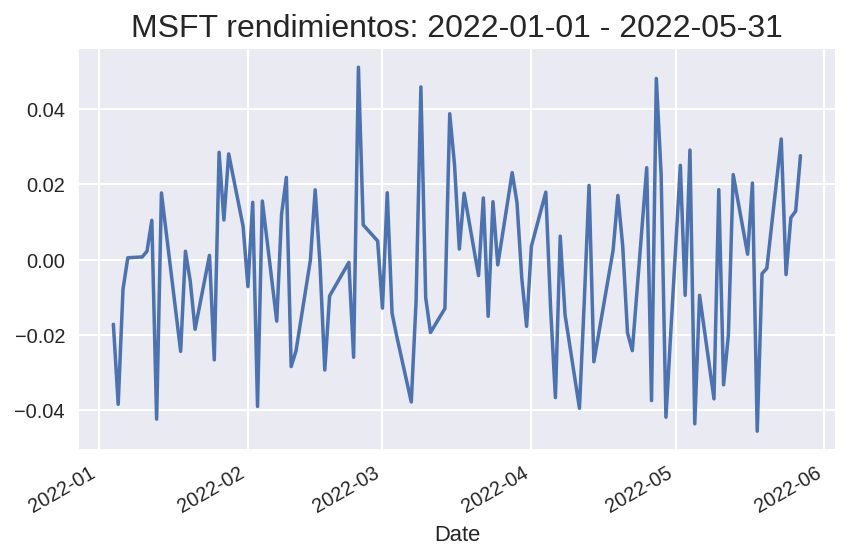

Rendimiento promedio: -0.17%


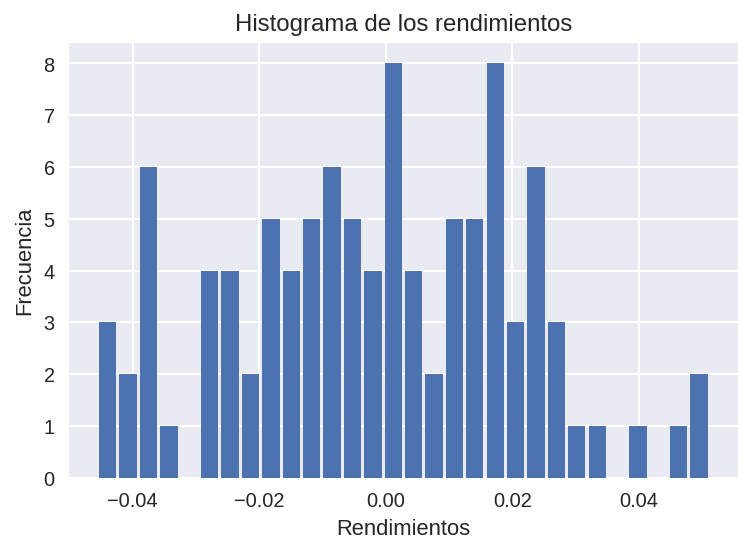

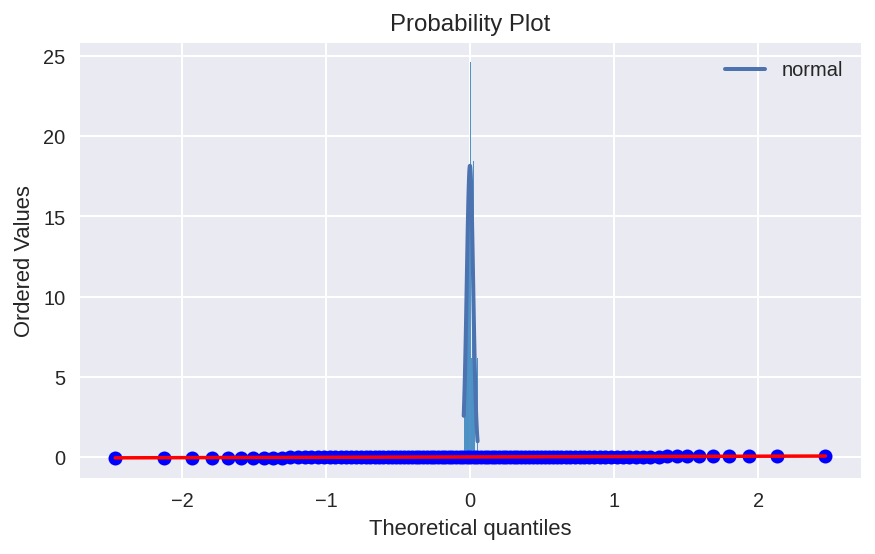

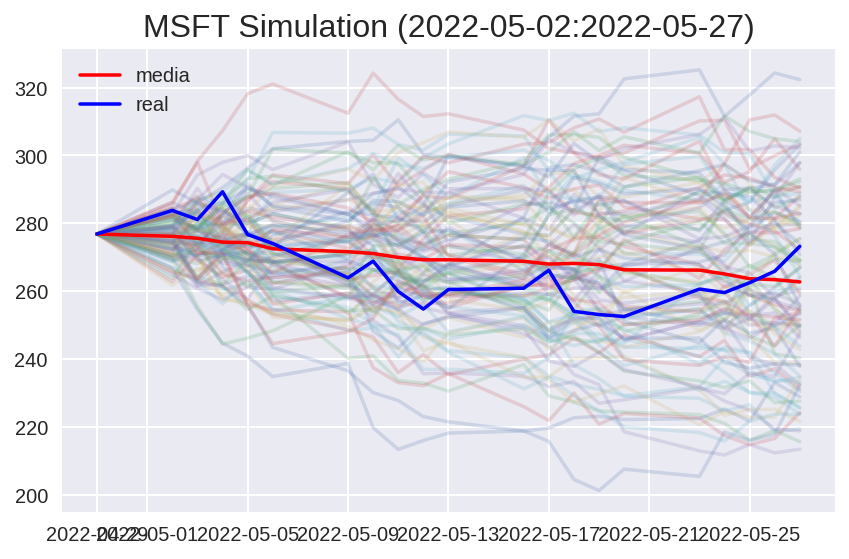

In [ ]:
import matplotlib.pyplot as plt
import warnings
!pip install yfinance 
plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternativa
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats

print("Datos de las acciones de Microsoft")

RISKY_ASSET = 'MSFT'
START_DATE = '2022-01-01'
END_DATE = '2022-05-31'

df = yf.download(RISKY_ASSET, start=START_DATE, end=END_DATE, adjusted=True)
print(f'Descargados {df.shape[0]} renglones de datos.')

#Calculando los rendimientos diarios

adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()   

ax = returns.plot()
ax.set_title(f'{RISKY_ASSET} rendimientos: {START_DATE} - {END_DATE}', 
             fontsize=16)


plt.tight_layout()
#plt.savefig('imagen1.png')
plt.show()

print(f'Rendimiento promedio: {100 * returns.mean():.2f}%')

#Graficar el histograma

plt.hist(x=returns, rwidth=0.85, bins=30)
plt.title('Histograma de los rendimientos')
plt.xlabel('Rendimientos')
plt.ylabel('Frecuencia')

plt.show()

print("\n\n")
train = returns['2021-01-01':'2022-04-30']
test = returns['2022-05-01':'2022-06-07']

T = len(test)   # longitud del periodo de predicción
N = len(test)   # número de incrementos unitarios en el periodo de predicción
S_0 = adj_close[train.index[-1]]  # precio inicial
N_SIM = 100

# Obtenemos los parametros del subconjunto de entrenamiento

mu = train.mean()    
sigma = train.std()

mu, sigma

from scipy import stats

x_hat = np.linspace(min(returns), max(returns), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=returns, density=True, bins=30, color="#3182bd", alpha=0.85)
ax.set_title('Distribución de rendimientos')
ax.set_xlabel('Rendimientos')
ax.set_ylabel('Frecuencia')
ax.legend();

import pylab 
stats.probplot(returns, dist="norm", plot=pylab)
pylab.show()
from scipy.stats import kstest
kstest(returns, 'norm', args=(mu, sigma))

def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=242):

    np.random.seed(random_seed)  # fijamos la semilla
    
    dt = T/N                     # incremento temporal
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps + sigma * W)   # Matriz (n_sim, T+1)
    S_t = np.insert(S_t, 0, s_0, axis=1)                 #Los reglones son trayectorias , columnas son tiempo
    
    return S_t
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)


last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation 'f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),   # se ponen datos simulados en un DF para visualizarlos
                                  index=index)
print("\n")
# Grafica
ax = gbm_simulations_df.plot(alpha=0.2, legend=False) # alpha hace transparentes las lineas
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('media', 'real'))

plt.tight_layout()
#plt.savefig('imagen2.png')
plt.show()
